# EMNIST character classification by class

This is the first approach to EMNIST character classification, based in reference code:

https://github.com/j05t/emnist

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle (2).json to kaggle (2).json
User uploaded file "kaggle (2).json" with length 76 bytes
mv: cannot stat 'kaggle.json': No such file or directory


##Download the dataset in .mat format

In [ ]:
!kaggle datasets download -d thousandping/emnistbyclassmat

Dataset URL: https://www.kaggle.com/datasets/thousandping/emnistbyclassmat
License(s): copyright-authors
 89% 229M/257M [00:01<00:00, 138MB/s]
100% 257M/257M [00:01<00:00, 151MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "/content/emnistbyclassmat.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


## Importing libraries

In [ ]:
import numpy as np
%matplotlib inline

# Load EMNIST Characters dataset by Class
downloaded from https://www.kaggle.com/datasets/thousandping/emnistbyclassmat (Matlab format dataset). The matlab format dataset can be conveniently imported with scipy.io.loadmat.

In [ ]:
from scipy import io as spio
emnist = spio.loadmat("/content/emnist-byclass.mat")

In [ ]:
# load training dataset
x_train = emnist["dataset"][0][0][0][0][0][0]
x_train = x_train.astype(np.float32)

# load training labels
y_train = emnist["dataset"][0][0][0][0][0][1]

In [ ]:

# load test dataset
x_test = emnist["dataset"][0][0][1][0][0][0]
x_test = x_test.astype(np.float32)

# load test labels
y_test = emnist["dataset"][0][0][1][0][0][1]

In [ ]:
# store labels for visualization
train_labels = y_train
test_labels = y_test

print (x_train.shape)
print (y_train.shape)

(697932, 784)
(697932, 1)


In [ ]:
# Preprocess input data, reshape using matlab order
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1, order="A")
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1, order="A")


## normalized to 16 colours instead of 255
numberofcolors = 16
colors = 255//(numberofcolors-1)
x_train /= colors
x_test /= colors

x_train.shape

(697932, 28, 28, 1)

In [ ]:
from tensorflow.keras.utils import to_categorical

# Preprocess class labels
## EMNIST ByClass: 814,255 characters. 62 unbalanced classes.
## Convert 1-dimensional class arrays to 62-dimensional class matrices

number_classes = 62

y_train = to_categorical(y_train, number_classes)
y_test = to_categorical(y_test, number_classes)

print(y_train.shape)
print(y_test.shape)

(697932, 62)
(116323, 62)


In [ ]:

class_idx = ['0','1','2','3','4','5','6','7','8','9',
             'A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z',
             'a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

In [ ]:
# which sample to look at
samplenum = 14500

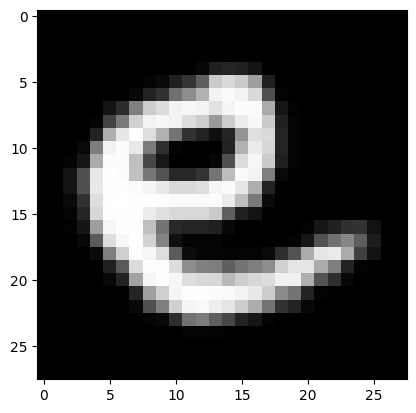

In [ ]:
import matplotlib.pyplot as plt
img = x_train[samplenum]

# visualize image
plt.imshow(img[:,:,0], cmap='gray')

In [ ]:
# show label for sample image
index = train_labels[samplenum][0]
class_idx[ index ]

'e'

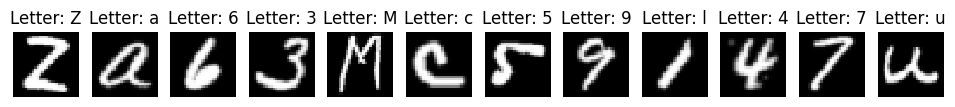

In [ ]:
# visualize train samples
fig = plt.figure(figsize=(12,6))
for i in range(12):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]
  plt.imshow(img[:,:,0], cmap='gray', interpolation='none')  # prints image
  index = train_labels[i][0]
  plt.title("Letter: " + str( class_idx[ index ] ))          # adds title to the letter or number

## Reshape test labels

In [ ]:
print ( test_labels.shape )
reshape = str(test_labels.shape).split(',')
reshape = int(reshape[0][1:])

(116323, 1)


In [ ]:
test_labels = test_labels.reshape( reshape )
test_labels.shape

(116323,)

## Data augmentation
Use keras data augmentation.

In [ ]:
batch_size = 512

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
gen = ImageDataGenerator(rotation_range=12, width_shift_range=0.1, shear_range=0.3,
                        height_shift_range=0.1, zoom_range=0.1, data_format='channels_last')
batches = gen.flow(x_train, y_train, batch_size=batch_size)
test_batches = gen.flow(x_test, y_test, batch_size=batch_size)
steps_per_epoch = int(np.ceil(batches.n/batch_size))
validation_steps = int(np.ceil(test_batches.n/batch_size))

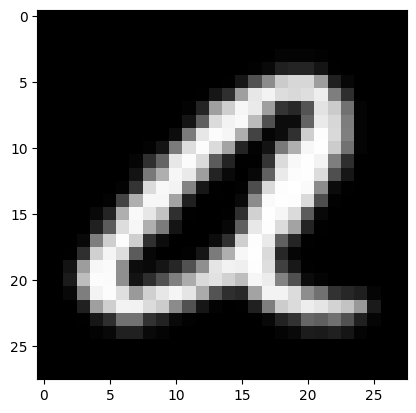

In [ ]:
import matplotlib.pyplot as plt

# load ONE image from training set to display on screen
img = x_train[1]

# visualize original image
plt.imshow(img[:,:,0], cmap='gray')

In [ ]:
# trick our generator into believing img has enough dimensions
# and get some augmented images for our single test image
img = np.expand_dims(img, axis=0)
aug_iter = gen.flow(img)

In [ ]:
aug_img = next(aug_iter)[0].astype(np.float32)
aug_img.shape

(28, 28, 1)

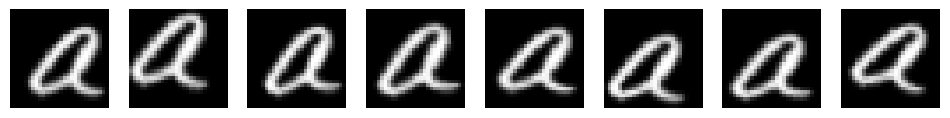

In [ ]:
import matplotlib.pyplot as plt

# show augmented images
f = plt.figure(figsize=(12,6))
for i in range(8):
    sp = f.add_subplot(2, 26//3, i+1)
    sp.axis('Off')
    aug_img = next(aug_iter)[0].astype(np.float32)
    plt.imshow(aug_img[:,:,0], cmap='gray')                 # images are stored as (img_size, image_size, channel)  to print it we should call it img [;,;,0]

# Build the Model

In [ ]:
import os                    # Load os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D

In [ ]:
x_train.shape

(697932, 28, 28, 1)

In [ ]:
len (y_train)

697932

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1), padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(62, activation = 'softmax')
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 2, 2, 128)         0

In [ ]:
# Compile model
model.compile(loss='categorical_crossentropy',
            optimizer='adam',
            metrics=['accuracy'])

In [ ]:
print("Logits shape:", model.output_shape)
print("Labels shape:", y_train.shape)

Logits shape: (None, 62)
Labels shape: (697932, 62)


In [ ]:
import tensorflow as tf

In [ ]:
#  Log to be reviewed with tensorboard
import time
from tensorflow.keras.callbacks import TensorBoard

#Define log name
log_name = 'EMNIST byClass-cnn-'+str (32) +'x'+ str(64)+'-{}'.format(int(time.time()))
tensorboard = TensorBoard(log_dir='logs/{}'.format(log_name))
!mkdir /content/logs1

#Train the model

In [ ]:
batch_size = 1024
epochs = 5

# Fit model on training data
history = model.fit(x_train, y_train
              , batch_size
              , epochs
              , verbose=1
              , callbacks = [tensorboard]
              , validation_data=(x_test, y_test)
             )

Epoch 1/5
682/682 [==============================] - 26s 29ms/step - loss: 0.6467 - accuracy: 0.7961 - val_loss: 0.4075 - val_accuracy: 0.8525
Epoch 2/5
682/682 [==============================] - 18s 26ms/step - loss: 0.4076 - accuracy: 0.8525 - val_loss: 0.3771 - val_accuracy: 0.8591
Epoch 3/5
682/682 [==============================] - 18s 26ms/step - loss: 0.3806 - accuracy: 0.8601 - val_loss: 0.3612 - val_accuracy: 0.8665
Epoch 4/5
682/682 [==============================] - 18s 26ms/step - loss: 0.3663 - accuracy: 0.8638 - val_loss: 0.3536 - val_accuracy: 0.8686
Epoch 5/5
682/682 [==============================] - 17s 25ms/step - loss: 0.3559 - accuracy: 0.8667 - val_loss: 0.3454 - val_accuracy: 0.8709


## Evaluate final accuracy

In [ ]:
# Evaluate model on test data
loss, accuracy = model.evaluate(x_test, y_test, verbose=0)
print ('Test loss ', loss )
print ('Test accuracy ', accuracy )

Test loss  0.3454383611679077
Test accuracy  0.8708939552307129


## Saving model

In [ ]:
save_dir = '/content/'
model_name = 'model - '+str (32) +'x'+ str(64)+' bs:' + str(batch_size) +' ep:'+ str(epochs) +' acc:'+ str(round(accuracy, 3)) +' loss:' + str(round(loss, 3)) +' .h5'

model_path = os.path.join(save_dir, model_name)
model.save( model_path )
print ('Saved trained model at ' + model_path )

Saved trained model at /content/model - 32x64 bs:1024 ep:5 acc:0.871 loss:0.345 .h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 347ms/step


Text(0.5, 1.0, 'Letter: T')

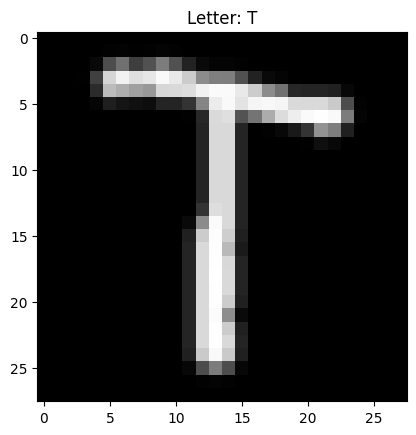

In [ ]:
import random
image_index = random.randint(1,len(x_test))

image = x_test[image_index] # show label for sample image
plt.imshow(image[:,:,0], cmap='gray', interpolation='none')

image = np.expand_dims(image, axis=0)
scores = model.predict(image)

index = np.argmax(scores)
plt.title("Letter: " + str( class_idx[ index ] ))

In [ ]:
# load the model and create predictions on the test set
# model = load_model(model_name)
predicted_probabilities = model.predict(x_test)

# Extract the predicted class for each sample
predicted_classes = np.argmax(predicted_probabilities, axis=1)

3636/3636 [==============================] - 9s 3ms/step


In [ ]:
#see which we predicted correctly and which not
correct_indices = np.nonzero(predicted_classes == test_labels)[0]
incorrect_indices = np.nonzero(predicted_classes != test_labels)[0]
print()
print(len(correct_indices)," classified correctly")
print(len(incorrect_indices)," classified incorrectly")


101305  classified correctly
15018  classified incorrectly


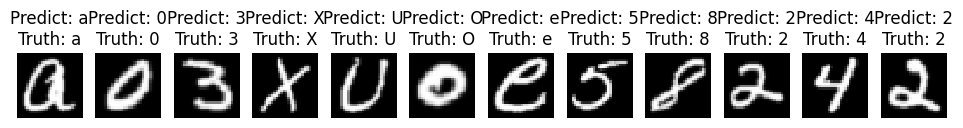

In [ ]:
fig = plt.figure(figsize=(12,6))
for i, correct in enumerate(correct_indices[:12]):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]
  plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')  # prints image
  plt.title(
      'Predict: ' + str(class_idx[predicted_classes[correct]]) +
      '\nTruth: ' + str(class_idx[test_labels[correct]])
  )

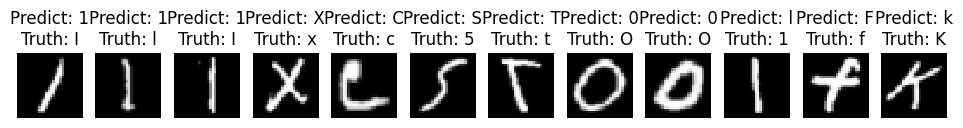

In [ ]:
fig = plt.figure(figsize=(12,6))
for i, correct in enumerate(incorrect_indices[:12]):
  rows = 2
  columns = 12
  sp = fig.add_subplot( rows, columns , i+1)                 # plot a matrix with 2 rows and 12 columns
  sp.axis('Off')                                             # removes background grill
  img = x_train[i]
  plt.imshow(x_test[correct].reshape(28,28), cmap='gray', interpolation='none')  # prints image
  plt.title(
      'Predict: ' + str(class_idx[predicted_classes[correct]]) +
      '\nTruth: ' + str(class_idx[test_labels[correct]])
  )